# Testing

Testing the visualisation and gradcam code for correctness on a toy dataset of random shapes.

In [4]:
%reload_ext autoreload
%autoreload 2

In [10]:
from skimage.draw import random_shapes
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image, ImageDraw

In [855]:
from src.data import *
from src.models.layers import *

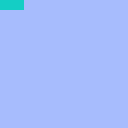

In [876]:
random_shapes(128, shape='rectangle', min_size=50, max_size=100, coord_limits=None, background='color', number=1)[0]

In [877]:
import torch
from torch import nn
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from fastai import *

In [878]:
from src.plots import *
from src.transforms import *

In [897]:
class Lambda(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
    
    def forward(self, x):
        return self.fn(x)

In [1034]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = conv(3, 24, strd=2, bn=True)
        self.conv2 = conv(24, 48, strd=2, bn=True)
        self.conv3 = conv(48, 64, bn=True)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.flatten = Lambda(lambda x: x.view(x.size(0),-1))
        self.head = nn.Linear(64, 3)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.head(self.flatten(self.pool(x)))
        return x

net = Network()

In [1035]:
class RandomShape(Dataset):
    def __init__(self, size, ds_length, tfms=None):
        self.size = size
        self.l = ds_length
        
    def __len__(self):
        return self.l
    
    def __getitem__(self, _):
        s = random_shapes(self.size, shape=None, min_size=self.size/2, max_size=100, 
                             coord_limits=None, background='uniform', number=1)
        return tfms(s[0]),s[1] if tfms is not None else s
    
tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])
dataset = RandomShape(64, 1000, tfms=tfms)
dl = DataLoader(dataset, 32)

In [1036]:
x,y = next(iter(dl))

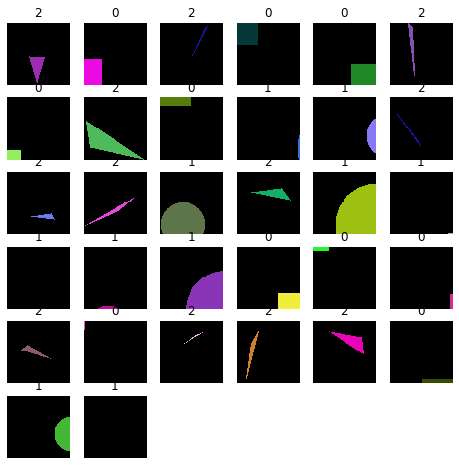

In [1037]:
show_images(x, normalize=True, figsize=(8,8), labels=y)

In [1038]:
def accuracy(y_hat, y):
    return (y_hat.argmax(-1) == y).float().mean().item()

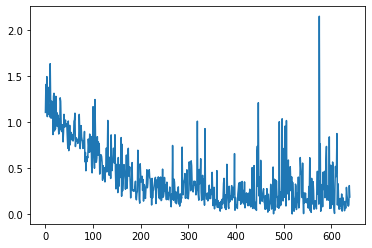

In [1039]:
optim = torch.optim.Adam(net.parameters(), lr=0.1, weight_decay=1e-5)
crit = nn.CrossEntropyLoss()
EPOCHS = 20

device=torch.device('cpu')
losses = []
accs = []
for epoch in range(EPOCHS):
    for x,y in dl:
        x,y = x.to(device),y.to(device)
        
        preds = net(x)
        loss = crit(preds, y)
        accs.append(accuracy(preds, y))
        losses.append(loss.item())
        
        loss.backward()
        optim.step()
        optim.zero_grad()
        
plt.plot(losses)

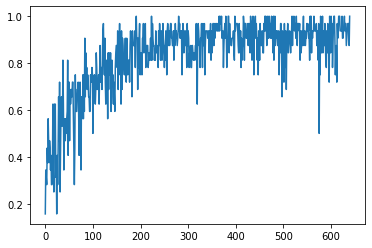

In [1040]:
plt.plot(accs)

In [1053]:
test_im, test_lb = next(iter(dl))

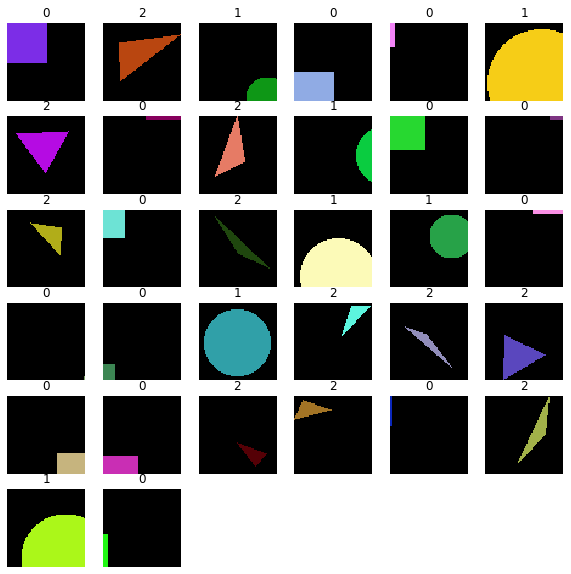

In [1054]:
show_images(test_im, normalize=True, labels=test_lb, figsize=(10,10))

In [1055]:
p = net(test_im)
p.argmax(-1)

tensor([0, 2, 1, 0, 0, 1, 2, 0, 2, 1, 0, 0, 2, 0, 2, 1, 1, 0, 0, 0, 1, 2, 2, 2,
        0, 0, 2, 2, 0, 2, 1, 0])

In [1056]:
test_lb

tensor([0, 2, 1, 0, 0, 1, 2, 0, 2, 1, 0, 0, 2, 0, 2, 1, 1, 0, 0, 0, 1, 2, 2, 2,
        0, 0, 2, 2, 0, 2, 1, 0])

In [1057]:
accuracy(p, test_lb)

1.0

## Interp

In [1058]:
from src.core import *
from src.interp.vis import *

In [1059]:
model = CutModel(net, 'conv3/0', np.random.randint(0,32))

Optimising for layer conv3/0, channel 17


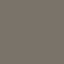

In [923]:
# input_img = random_im(64)
input_img = fourier_image(64)
denorm(input_img)

0 35.69929885864258


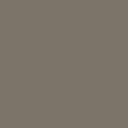

100 27.477312088012695


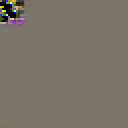

200 -69.17835235595703


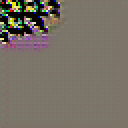

300 -307.137939453125


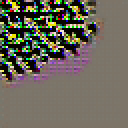

400 -613.434814453125


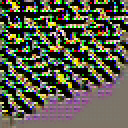

500 -871.0413818359375


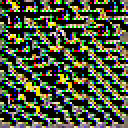

In [924]:
model.vis(input_img, iters=501, transform=False, decorrelate=False)

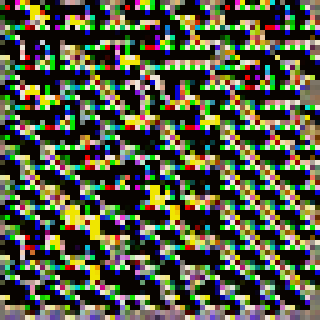

In [925]:
zoom(denorm(input_img), 5)

### Grad-CAM

In [1060]:
from src.hooks import *
from src.core import *
from src.transforms import denorm
from src.interp.gradCAM import gradcam

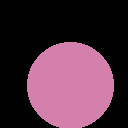

In [1146]:
img, label = random_shapes(128, shape='circle', min_size=50, max_size=100, coord_limits=None, background='uniform', number=1)
img

In [1147]:
label

1

In [1148]:
tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])

In [1149]:
img = tfms(img)
net(img[None]).argmax(-1)

tensor([1])

In [1150]:
net.unfreeze()

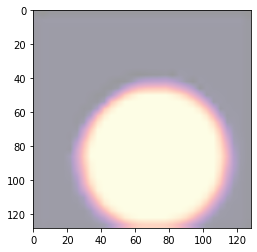

In [1158]:
gradcam(net, img[None], 1, layer='conv3/0', show_im=False);